<a href="https://colab.research.google.com/github/pihk94/DeepLearning/blob/master/Cycle_GAN_Implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning : Generative Adversarial Networksand Cycle-GAN
### May 2020 / ENSAE 
###### Melchior Prugniaud

The purpose of this notebook is to reproduce the Cycle Gan presented [here](https://junyanz.github.io/CycleGAN/) which is an Image to Image translation and transform the MNIST dataset to the USPS. 

Following the [proposed assignment](http://www.cs.toronto.edu/~rgrosse/courses/csc421_2019/assignments/assignment4.pdf), we will :

* Implement Deep Convolutionnal GAN

* Implement Cycle GAN

But first of all we need to import some packages and both dataset. I will use tensorflow and keras to do it.

In [2]:
!pip install git+https://www.github.com/keras-team/keras-contrib.git

  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-qmwot2fh
  Running command git clone -q https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-qmwot2fh
  Created wheel for keras-contrib: filename=keras_contrib-2.0.8-cp36-none-any.whl size=101064 sha256=cdee27118c5a8a67b2b396b34e1d13578f133e0d79d7915f226b73123b2337a2
  Stored in directory: /tmp/pip-ephem-wheel-cache-3h1mk6qx/wheels/11/27/c8/4ed56de7b55f4f61244e2dc6ef3cdbaff2692527a2ce6502ba
Successfully built keras-contrib


In [0]:
import tensorflow as tf
from tensorflow.keras.backend import resize_images
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt
import cv2
from skimage.transform import resize
import numpy as np

# Prerequisite Datasets preprocessing

### Load MNIST Dataset
MNIST dataset consist of 70 000 digits of size 28x28.

In [0]:
train_mnist,test_mnist = mnist.load_data()
train_mnist[0].shape,train_mnist[1].shape

11493376/11490434 [==============================] - 0s 0us/step


((60000, 28, 28), (60000,))

In [0]:
img_mnist,label_mnist = train_mnist[0],train_mnist[1]
imgs,labels = [],[]
j=0
while len(imgs)<=9:
  for i in range(len(img_mnist)):
    if not label_mnist[i] in labels and label_mnist[i] ==j:
      labels.append(label_mnist[i])
      imgs.append(img_mnist[i])
      j+=1

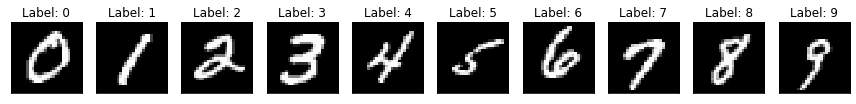

In [0]:
plt.figure(figsize =(12,12))
for i in range(1,11):
  plt.subplot(1,10,i)
  plt.imshow(imgs[i-1],cmap='gray',interpolation='none')
  plt.title("Label: {}".format(labels[i-1]))
  plt.xticks([])
  plt.yticks([])
plt.tight_layout()

Let's try to resize our image to 32 x 32 as asked in the input from the assignment.


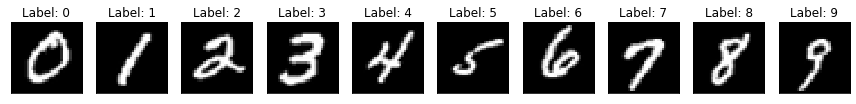

In [0]:
plt.figure(figsize =(12,12))
for i in range(1,11):
  plt.subplot(1,10,i)
  plt.imshow(cv2.resize(imgs[i-1], dsize=(32,32), interpolation=cv2.INTER_CUBIC),cmap='gray',interpolation='none')
  plt.title("Label: {}".format(labels[i-1]))
  plt.xticks([])
  plt.yticks([])
plt.tight_layout()

Looks like it's working good, we will apply it on a function to prepare datasets.
### Load USPS dataset

Let's now load the USPS dataset, unfortunately keras does not have the dataset, so we load it with torchvision.


In [0]:
from torchvision import datasets
train_usps = datasets.USPS(root='content/',download=True,train=True)
test_usps = datasets.USPS(root='content/',download=True,train=False)

In [0]:
train_usps[0]

(<PIL.Image.Image image mode=L size=16x16 at 0x7F025A020278>, 6)

In [0]:
data = train_usps
imgs,labels = [],[]
j=0
while len(imgs)<=9:
  for i in range(len(data)):
    if not data[i][1] in labels and data[i][1] ==j:
      labels.append(data[i][1])
      imgs.append(data[i][0])
      j+=1

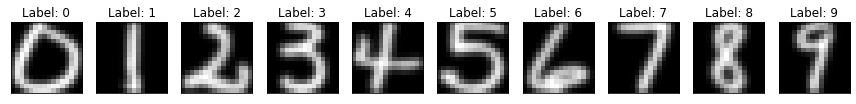

In [0]:
plt.figure(figsize =(12,12))
for i in range(1,11):
  plt.subplot(1,10,i)
  plt.imshow(imgs[i-1],cmap='gray',interpolation='none')
  plt.title("Label: {}".format(labels[i-1]))
  plt.xticks([])
  plt.yticks([])
plt.tight_layout()

Let's reshape again this 16x16 imgs to 32x32

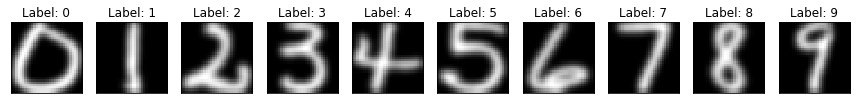

In [0]:
plt.figure(figsize =(12,12))
for i in range(1,11):
  plt.subplot(1,10,i)
  plt.imshow(imgs[i-1].resize((32,32)),cmap='gray',interpolation='none')
  plt.title("Label: {}".format(labels[i-1]))
  plt.xticks([])
  plt.yticks([])
plt.tight_layout()

## Prepare datasets loader

Here is two function , one for each dataset to load data in the good format for our networks.

# Part 1: Deep Convolutional GAN (DCGAN)

In the first part, the assignment ask to implement the DCGAN.
We will follow this blueprint : 

* Create discriminator

* Create generator

* Create the training procedure


## Discriminator

We have to reproduce this architecture : 


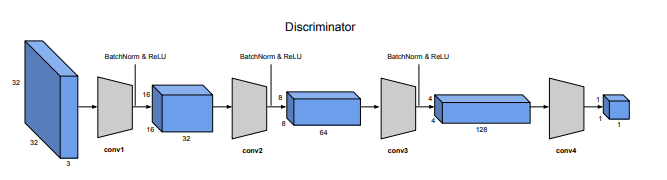

In [0]:
from keras.layers import Conv2D, LeakyReLU, Activation, Concatenate, BatchNormalization
from keras.models import Input, Model
from keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.utils.vis_utils import plot_model
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization

def discriminator(input_shape):
  init = RandomNormal(stddev=0.02) #as used in the article of CycleGan
  Input_image= Input(shape= input_shape)
  padding = 'same'
  kernels = (4,4)
  strides = (2,2)
  size = 64
  conv1 = Conv2D(size,kernels,strides =strides,padding = padding,kernel_initializer=init)(Input_image)
  conv1 = LeakyReLU(alpha=0.05)(conv1)
  conv2 = Conv2D(size*2,kernels,strides =strides,padding = padding,kernel_initializer=init)(conv1)
  conv2 = InstanceNormalization(axis=-1)(conv2)
  conv2 = LeakyReLU(alpha=0.05)(conv2)
  conv3 = Conv2D(size*4,kernels,strides =strides,padding = padding,kernel_initializer=init)(conv2)
  conv3 = InstanceNormalization(axis=-1)(conv3)
  conv3 = LeakyReLU(alpha=0.05)(conv3)
  out = Conv2D(1,kernels,padding = padding,kernel_initializer=init)(conv3)
  model = Model(Input_image,out)
  model.compile(loss='mse',optimizer=Adam(lr=0.0002,beta_1=0.5),metrics = ['accuracy'],loss_weights=[0.5]) 
  return model

Taking our initial shape, we got the following model for our discriminator.

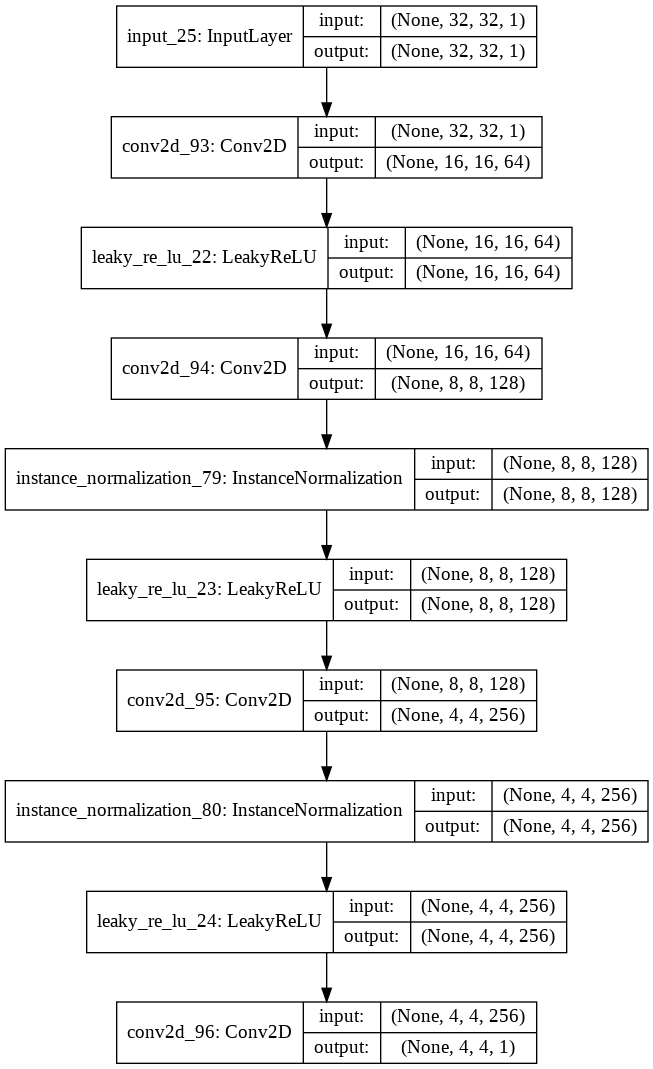

In [141]:
plot_model(discriminator((32,32,1)), to_file='discriminator_model_plot.png', show_shapes=True, show_layer_names=True,)

## Generator

Let's now try to make the generator model. The representation is : 

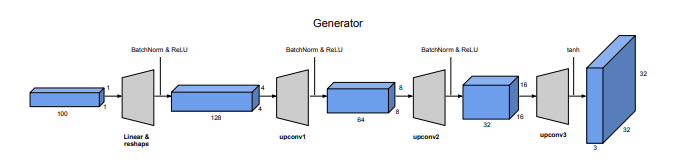

In [0]:
from keras.layers import Conv2DTranspose, Activation
def generator(input_shape):
  init = RandomNormal(stddev=0.02) #as used in the article of CycleGan
  Input_image= Input(shape= input_shape)
  conv1 = Conv2D(64,(4,4),strides=(2,2),padding='same',kernel_initializer=init)(Input_image)
  conv1 = Activation('relu')(conv1)
  conv2 = Conv2D(64*2,(4,4),strides=(2,2),padding='same',kernel_initializer=init)(conv1)
  conv2 = InstanceNormalization(axis=-1)(conv2)
  conv2 = Activation('relu')(conv2)
  conv3 = Conv2D(64*2,(3,3),strides=(1,1),padding='same',kernel_initializer=init)(conv2)
  conv3 = InstanceNormalization(axis=-1)(conv3)
  conv3 = Activation('relu')(conv3)
  conv4 = Conv2D(64*2,(3,3),strides=(1,1),padding='same',kernel_initializer=init)(conv3)
  conv4 = InstanceNormalization(axis=-1)(conv4)
  conv4 = Activation('relu')(conv4)
  deconv1 = Conv2DTranspose(64,(4,4),strides=(2,2),padding='same',kernel_initializer=init)(conv4)
  deconv1 = InstanceNormalization(axis=-1)(deconv1)
  deconv1 = Activation('relu')(deconv1)
  deconv2 = Conv2DTranspose(1,(4,4),strides=(2,2),padding='same',kernel_initializer=init)(deconv1)
  deconv2 = Activation('tanh')(deconv2)
  model = Model(Input_image,deconv2)
  return model

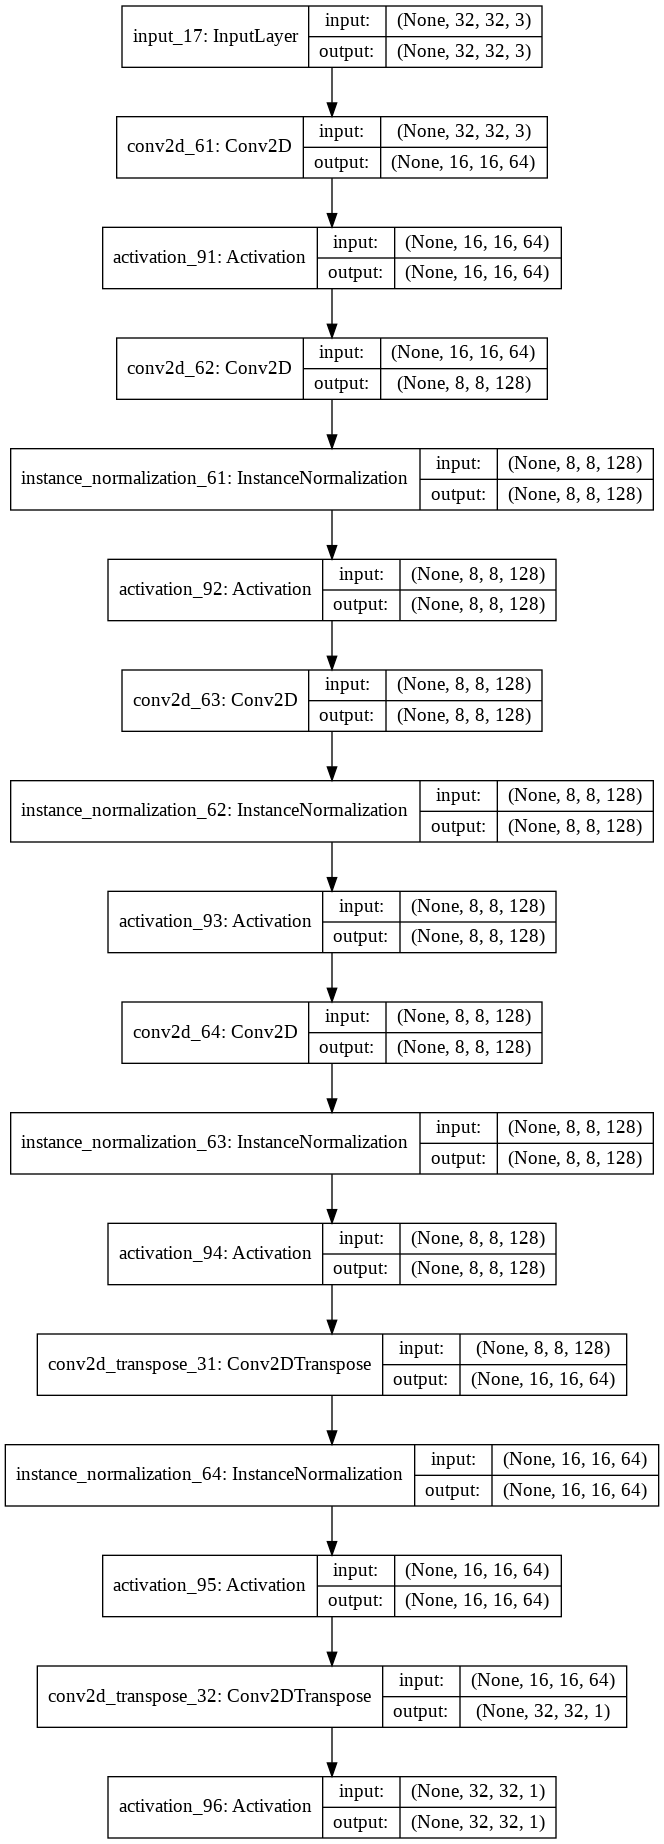

In [35]:
plot_model(generator((32,32,3)), to_file='generator_model_plot.png', show_shapes=True, show_layer_names=True,)

## Training Loop


In [0]:
def load_mnist():
  (trainX,_),(_,_) = mnist.load_data()
  trainX = np.expand_dims(trainX, axis=-1)
  X = resize(trainX, (60000,32,32))
  return X
def real_samples(df,n_samples):
  ix = np.random.randint(0, df.shape[0], n_samples)
  X = df[ix]
  y = np.ones((n_samples,4,4,1))
  return X,y
def fake_samples(n_samples):
  X = np.random.rand(32*32*n_samples)
  X = X.reshape((n_samples,32,32,1))
  y = np.zeros((n_samples,4,4,1))
  return X,y
def train_discriminator(model, df, n_iter = 100,batch_size = 64,show_every=10):
  semi_batch = int(batch_size/2)
  for i in range(n_iter):
    X_real,y_real = real_samples(df,semi_batch)
    _, trueAcc = model.train_on_batch(X_real,y_real)
    X_fake,y_fake = fake_samples(semi_batch)
    _, fakeAcc = model.train_on_batch(X_fake,y_fake)
    if not i % show_every:
      print(f'Accuracy show for iter {i} :\nReal : {round(trueAcc*100,2)} Fake : {round(fakeAcc*100,2)}')

In [170]:
df = load_mnist()
model = discriminator((32,32,1))
train_discriminator(model,df,n_iter=200)

Accuracy show for iter 0 :
Real : 9.77 Fake : 57.42
Accuracy show for iter 10 :
Real : 79.3 Fake : 74.61
Accuracy show for iter 20 :
Real : 92.77 Fake : 82.03
Accuracy show for iter 30 :
Real : 86.33 Fake : 79.88
Accuracy show for iter 40 :
Real : 98.24 Fake : 89.45
Accuracy show for iter 50 :
Real : 96.68 Fake : 91.99
Accuracy show for iter 60 :
Real : 95.9 Fake : 93.36
Accuracy show for iter 70 :
Real : 99.61 Fake : 95.31
Accuracy show for iter 80 :
Real : 99.41 Fake : 99.22
Accuracy show for iter 90 :
Real : 99.41 Fake : 95.12
Accuracy show for iter 100 :
Real : 99.8 Fake : 94.53
Accuracy show for iter 110 :
Real : 100.0 Fake : 99.61
Accuracy show for iter 120 :
Real : 100.0 Fake : 100.0
Accuracy show for iter 130 :
Real : 100.0 Fake : 99.41
Accuracy show for iter 140 :
Real : 100.0 Fake : 100.0
Accuracy show for iter 150 :
Real : 100.0 Fake : 99.8
Accuracy show for iter 160 :
Real : 99.22 Fake : 99.8
Accuracy show for iter 170 :
Real : 100.0 Fake : 100.0
Accuracy show for iter 180 

In [0]:
def generator_fake_samples(model,n_samples):
  x_input = np.random.randn(32*32*n_samples)
  x_input = x_input.reshape((n_samples,32,32,1))
  X = model.predict(x_input)
  y = np.zeros((n_samples,4,4,1))
  return X,y

In [0]:
model = generator((32,32,1))

In [0]:
X,_ = generator_fake_samples(model,25)

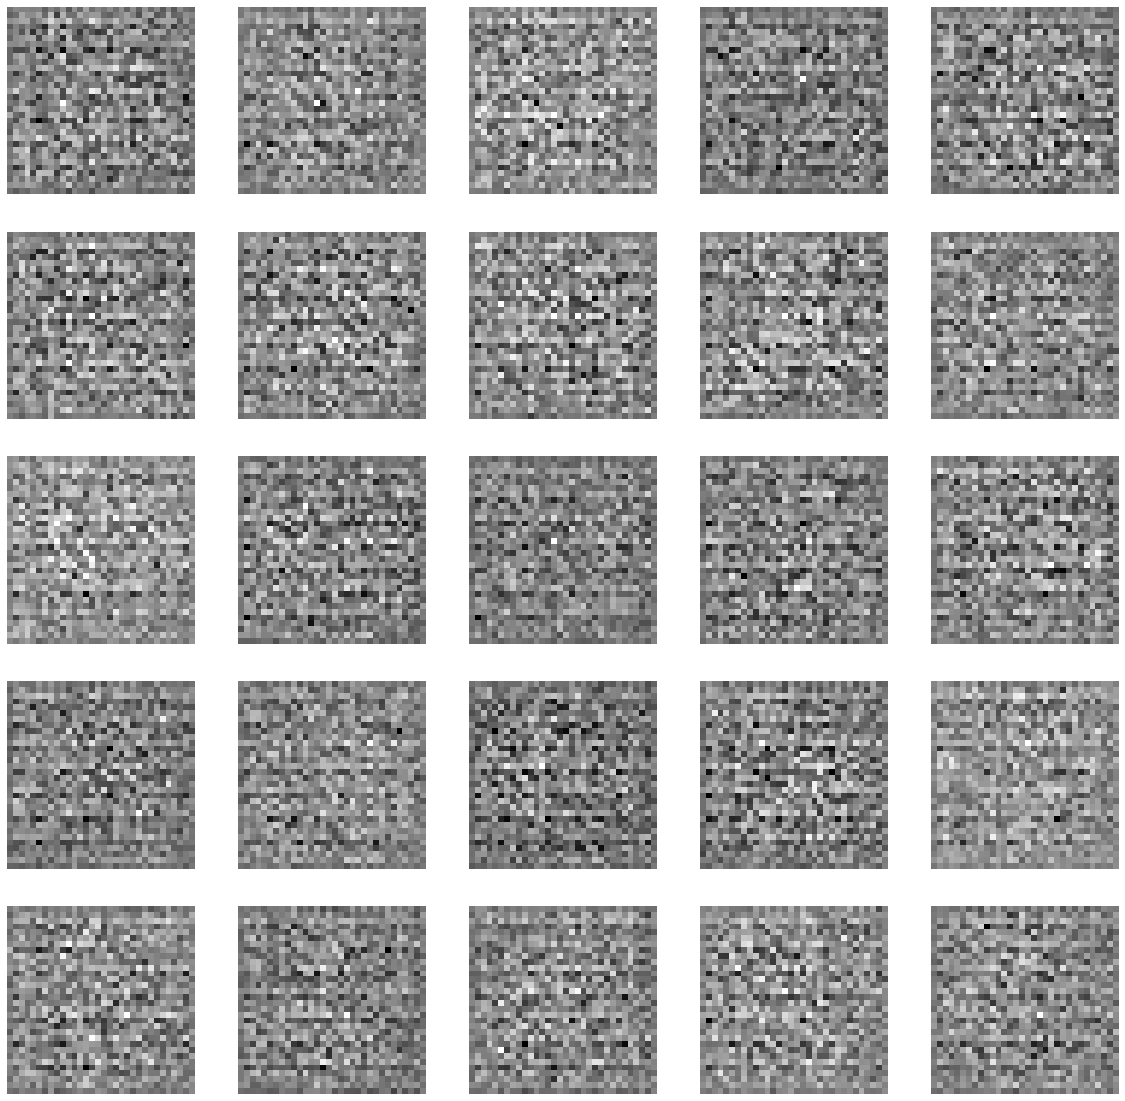

In [176]:
plt.figure(figsize=(20,20))
for i in range(25):
	# define subplot
	plt.subplot(5, 5, 1 + i)
	# turn off axis labels
	plt.axis('off')
	# plot single image
	plt.imshow(X[i, :, :, 0], cmap='gray_r')
# show the figure
